In [1]:
import pandas as pd
import xml.etree.ElementTree as et
import re,time
from bs4 import BeautifulSoup
import sqlite3
import numpy as np
import pygtrie
from matplotlib import pyplot as plt
from py2neo import Graph, Node, Relationship

In [2]:
def getColumns(xml_str):
    return [re.sub(r"[\n\t\s]*", "", part) for part in xml_str.split('-')]

In [78]:
user_cols = getColumns('''Id
     - Reputation
     - CreationDate
     - DisplayName
     - EmailHash
     - LastAccessDate
     - WebsiteUrl
     - Location
     - Age
     - AboutMe
     - Views
     - UpVotes
     - DownVotes''')
post_cols = getColumns('''Id
       - PostTypeId
       - ParentId
       - AcceptedAnswerId
       - CreationDate
       - Score
       - ViewCount
       - Body
       - OwnerUserId
       - LastEditorUserId
       - LastEditorDisplayName
       - LastEditDate
       - LastActivityDate
       - CommunityOwnedDate
       - ClosedDate
       - Title
       - Tags
       - AnswerCount
       - CommentCount
       - FavoriteCount''')
comment_cols= getColumns('''Id
       - PostId
       - Score
       - Text
       - CreationDate
       - UserId''')
badges_cols = getColumns('''UserId
       - Name
       - Date''')
posthistory_cols = getColumns('''Id
- PostHistoryTypeId
- PostId
- RevisionGUID
- CreationDate
- UserId
- UserDisplayName
- Comment
    - Text
- CloseReasonId''')
postlinks_cols = getColumns('''Id
     - CreationDate
     - PostId
     - RelatedPostId
     - LinkTypeId''')
votes_cols = getColumns('''Id
     - PostId
     - VoteTypeId
     - CreationDate
     - UserId
     - BountyAmount''')
tags_cols = ['TagName','Count','ExcerptPostId','WikiPostId']

In [4]:
def getDataFrame(file, cols, html_clean_cols):
    xtree = et.parse(file)
    root = xtree.getroot()
    rows = []
    html_clean_cols = set(html_clean_cols)
    for node in root:
        row = []
        for col in cols:
            if node is not None and node.attrib.get(col) is not None: 
                if col in html_clean_cols:
                    row.append(BeautifulSoup(node.attrib.get(col)).get_text())
                else:
                    row.append(node.attrib.get(col))
            else:
                row.append(None)
        rows.append({col: row[i] for i, col in enumerate(cols)})
    return pd.DataFrame(rows, columns=cols)

In [303]:
df_user = getDataFrame('Users.xml',user_cols,['AboutMe'])
df_post = getDataFrame('Posts.xml',post_cols,[])
df_comment = getDataFrame('Comments.xml', comment_cols,[])
df_badges = getDataFrame('Badges.xml', badges_cols, [])
df_post_history = getDataFrame('PostHistory.xml', posthistory_cols, [])
df_tags = getDataFrame('Tags.xml', tags_cols, [])
df_post_links = getDataFrame('PostLinks.xml', postlinks_cols, [])
df_votes = getDataFrame('Votes.xml', votes_cols, [])


/home/sushil/anaconda3/envs/gplot/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [309]:
df_user.columns
df_post.Score = pd.to_numeric(df_post.Score, errors='coerce').fillna(0).astype(np.int64)
df_comment.Score = pd.to_numeric(df_comment.Score, errors='coerce').fillna(0).astype(np.int64)
df_post['CreationDate'] = pd.to_datetime(df_post['CreationDate'])
df_votes['CreationDate'] = pd.to_datetime(df_votes['CreationDate'])
df_post_links['CreationDate'] = pd.to_datetime(df_post_links['CreationDate'])
df_post['ViewCount'] = pd.to_numeric(df_post['ViewCount'])
df_votes['CreationDate'] = pd.to_datetime(df_votes['CreationDate'])

In [334]:

tag_map = []
trie = pygtrie.CharTrie()
for i, row in df_post.iterrows():
    if row['PostTypeId'] == '2':
        continue
    if row['Tags'] is None:
        continue
    tags = row['Tags'].split('<')
    tags = tags[1:]
    for tag in tags:
        if tag[:-1] in trie:
            trie[tag[:-1]].add(row['Id'])
        else:
            trie[tag[:-1]] = set([row['Id']])
        if tag[:-1] in df_tags['TagName'].values:
            tag_map.append({'Id': row['Id'], 'tagId': tag[:-1]})
df_tag_map = pd.DataFrame(tag_map, columns=['Id','tagId'])


In [31]:
con = sqlite3.connect('test.db')
cur = con.cursor()


In [40]:
pp = 0
if pp == 0:
    df_user.to_csv(index=False)
    df_post.to_csv(index=False)
    df_comment.to_csv(index=False)
    df_badges.to_csv(index=False)
    df_post_history.to_csv(index=False)
    df_tags.to_csv(index=False)
    df_post_links.to_csv(index=False)
    df_votes.to_csv(index=False)
    df_tag_map.to_csv(index=False)
#     df_tag_map.to_sql(name='tag_map', if_exists='replace', con=con)
#     df_user.to_sql(name='user', if_exists='replace', con=con)
#     df_post.to_sql(name='post', if_exists='replace',con=con)
#     df_comment.to_sql(name='comment', if_exists='replace',con=con)
#     df_badges.to_sql(name='badges', if_exists='replace',con=con)
#     df_post_history.to_sql(name='post_history', if_exists='replace',con=con)
#     df_tags.to_sql(name='tags', if_exists='replace',con=con)
#     df_post_links.to_sql(name='post_links',if_exists='replace', con=con)
#     df_votes.to_sql(name='votes', if_exists='replace',con=con)

In [23]:
df_post.columns
post_cols
# df_votes.to_sql(name='votes', if_exists='replace',con=con)
df_post.to_sql(name='post',if_exists='replace',con=con)

In [71]:
df_post[df_post['PostTypeId'] == '1']['CreationDate']

0       2014-05-13 23:58:30.457
1       2014-05-14 00:11:06.457
4       2014-05-14 01:25:59.677
5       2014-05-14 01:41:23.110
6       2014-05-14 01:57:56.880
                  ...          
39923   2019-08-31 20:01:31.103
39925   2019-08-31 23:27:15.300
39926   2019-08-31 23:37:42.300
39927   2019-09-01 01:55:53.753
39928   2019-09-01 03:14:54.797
Name: CreationDate, Length: 18513, dtype: datetime64[ns]

pandas.core.frame.DataFrame

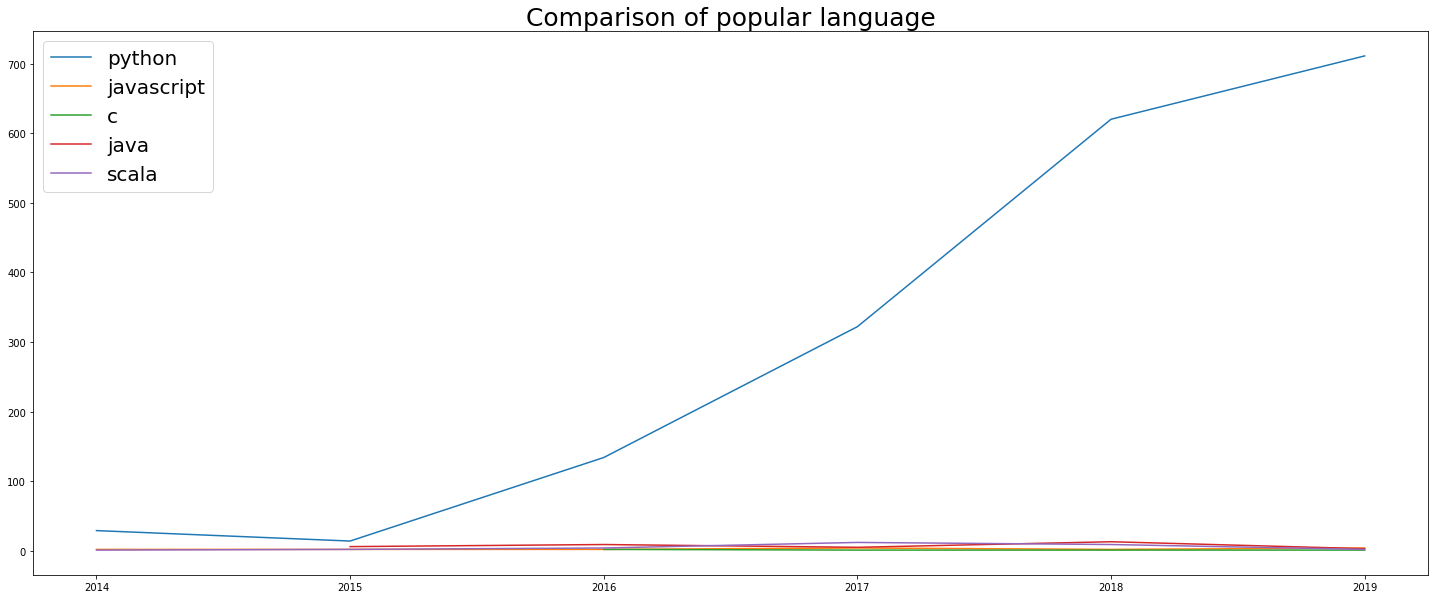

In [314]:
def getAxis(df, col):
    if col is None:
        col = 'Body'
    X = []
    Y = []
    for index, group in df.iterrows():
        Y.append(group[col])
        X.append(index)
    return (X,Y)
def getPopularPL():
    language = ['python','javascript','c','java','scala']
    dfs = []
    fig, ax = plt.subplots()
    for p in language:
        dfs.append((p,df_post[df_post.index.isin(trie[p])].groupby(by=df_post.CreationDate.dt.year).count()))
    for d in dfs:
        axis = getAxis(d[1],None)
        ax.plot(axis[0],axis[1],label=d[0])
    plt.rcParams['figure.figsize'] = [25, 10]
    ax.legend(prop={'size': 20})
    plt.title('Comparison of popular language', fontsize=25)
    plt.show()
getPopularPL()

/home/sushil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sushil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/sushil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/sushil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/home/sushil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/sushil/.local/lib/python3.6/site-packages/ipykernel_launcher

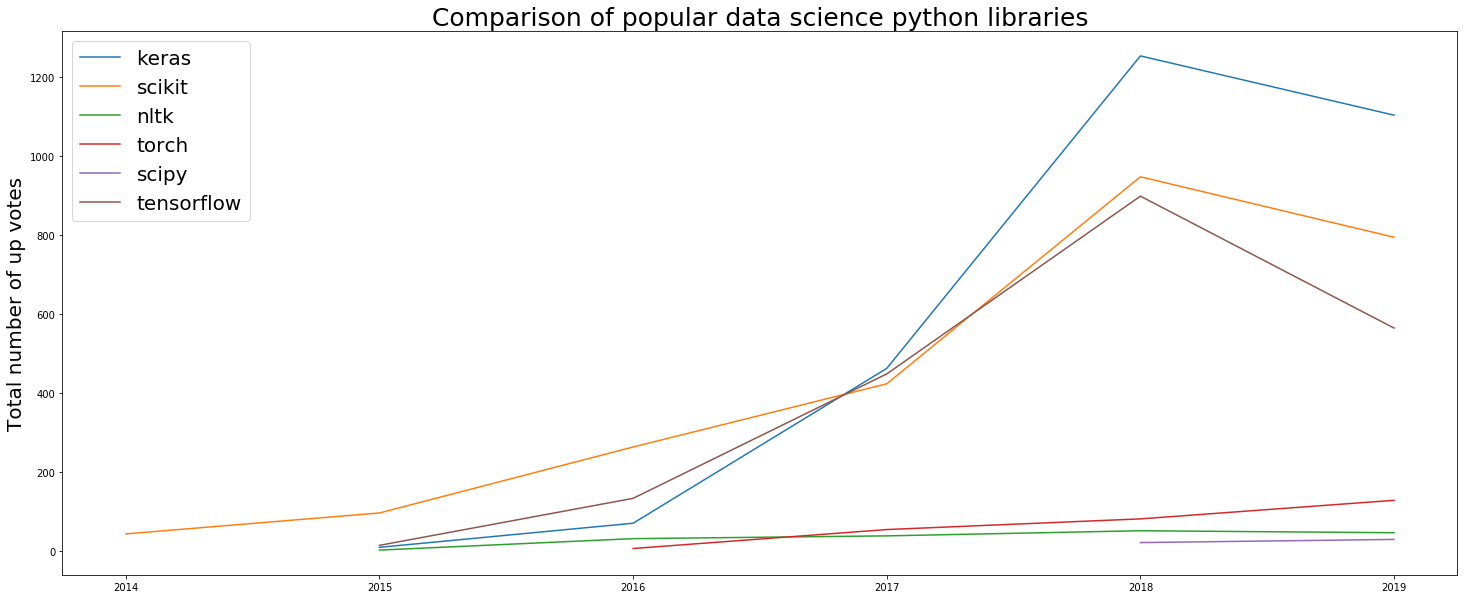

In [335]:

def getUpVoteTrend():
    dfs = []
    df_keras = df_votes.loc[df_votes['VoteTypeId'] == '2'][df_votes['PostId'].isin(trie['keras'])].groupby(by=df_votes.CreationDate.dt.year).count()
    dfs.append(('keras',df_keras))
    df_scikit = df_votes.loc[df_votes['VoteTypeId'] == '2'][df_votes['PostId'].isin(trie['scikit-learn'])].groupby(by=df_votes.CreationDate.dt.year).count()
    dfs.append(('scikit',df_scikit))
    df_nltk = df_votes.loc[df_votes['VoteTypeId'] == '2'][df_votes['PostId'].isin(trie['nltk'])].groupby(by=df_votes.CreationDate.dt.year).count()
    dfs.append(('nltk',df_nltk))
    df_torch = df_votes.loc[df_votes['VoteTypeId'] == '2'][df_votes['PostId'].isin(trie['pytorch'].union(trie['torch']))].groupby(by=df_votes.CreationDate.dt.year).count()
    dfs.append(('torch',df_torch))
    df_scipy = df_votes.loc[df_votes['VoteTypeId'] == '2'][df_votes['PostId'].isin(trie['scipy'])].groupby(by=df_votes.CreationDate.dt.year).count()
    dfs.append(('scipy',df_scipy))
    df_tensorflow = df_votes.loc[df_votes['VoteTypeId'] == '2'][df_votes['PostId'].isin(trie['tensorflow'])].groupby(by=df_votes.CreationDate.dt.year).count()
    dfs.append(('tensorflow',df_tensorflow))
    fig, ax = plt.subplots()
    for d in dfs:
        axes = getAxis(d[1],'PostId')
        ax.plot(axes[0],axes[1],label=d[0])
    plt.rcParams['figure.figsize'] = [25, 10]
    ax.legend(prop={'size': 20})
    plt.title('Comparison of popular data science python libraries', fontsize=25)
    plt.ylabel('Total number of up votes',fontsize=20)
    plt.show()
getUpVoteTrend()


In [323]:
df_votes.loc[df_votes['VoteTypeId'] == 2][df_votes['PostId'].isin(trie['keras'])].groupby(by=df_votes.CreationDate.dt.year).count()

/home/sushil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Id,PostId,VoteTypeId,CreationDate,UserId,BountyAmount
CreationDate,,,,,,


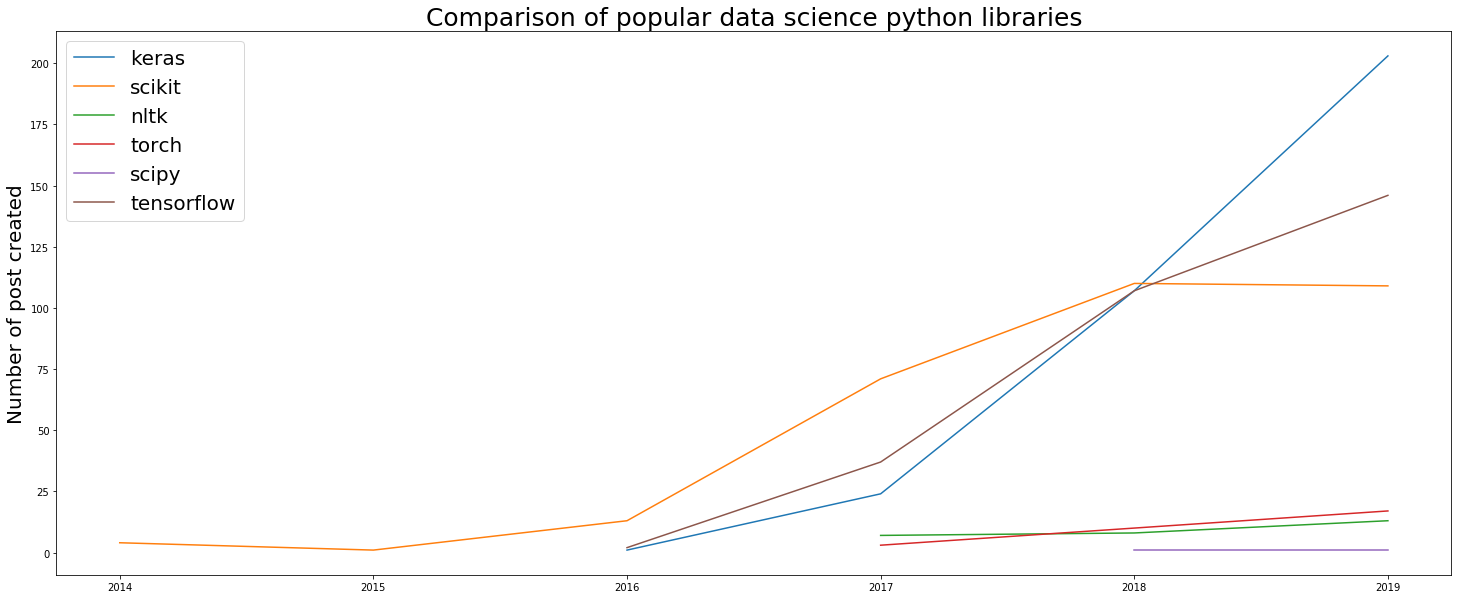

In [336]:
def getLibraryPop():
    dfs = []
    df_p = df_post[df_post['PostTypeId'] == '1']
    df_keras = df_p[df_p.index.isin(trie['keras'])].groupby(by=df_p.CreationDate.dt.year).count()
    dfs.append(('keras',df_keras))
    df_scikit = df_p[df_p.index.isin(trie['scikit-learn'])].groupby(by=df_p.CreationDate.dt.year).count()
    dfs.append(('scikit',df_scikit))
    df_nltk = df_p[df_p.index.isin(trie['nltk'])].groupby(by=df_p.CreationDate.dt.year).count()
    dfs.append(('nltk',df_nltk))
    df_torch = df_p[df_p.index.isin(trie['pytorch'].union(trie['torch']))].groupby(by=df_p.CreationDate.dt.year).count()
    dfs.append(('torch',df_torch))
    df_scipy = df_p[df_p.index.isin(trie['scipy'])].groupby(by=df_p.CreationDate.dt.year).count()
    dfs.append(('scipy',df_scipy))
    df_tensorflow = df_p[df_p.index.isin(trie['tensorflow'])].groupby(by=df_p.CreationDate.dt.year).count()
    dfs.append(('tensorflow',df_tensorflow))
    fig, ax = plt.subplots()
    for d in dfs:
        axis = getAxis(d[1],None)
        ax.plot(axis[0],axis[1],label=d[0])
    plt.rcParams['figure.figsize'] = [25, 10]
    ax.legend(prop={'size': 20})
    plt.title('Comparison of popular data science python libraries', fontsize=25)
    plt.ylabel('Number of post created',fontsize=20)
    plt.show()
getLibraryPop()

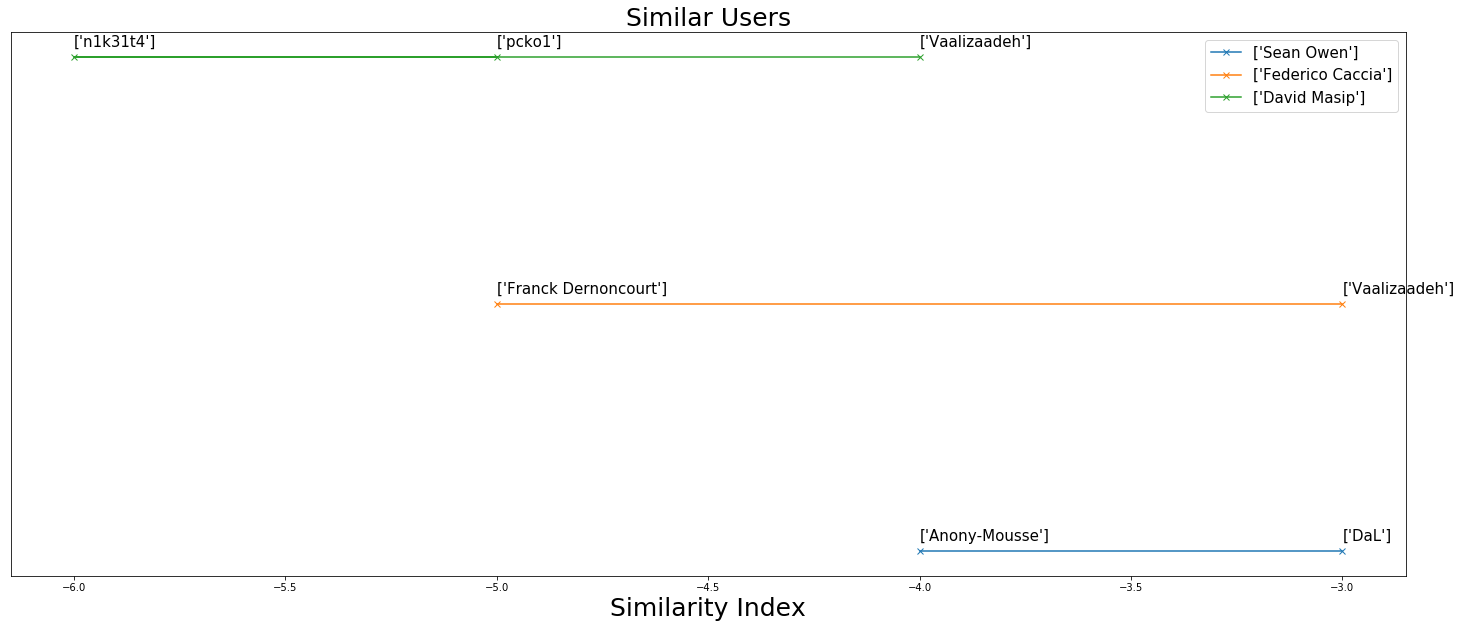

In [278]:
def getDisplayName(id):
    return df_user[df_user['Id'] == id]['DisplayName'].values

def getSimilarUser(user_ids):
    graph = Graph('http://localhost:7474', auth=('neo4j','svr2007'))
    a = graph.run('''MATCH (r1:Reply)-[:answered]-(p:Post)-[:answered]-(r2:Reply) WHERE r2.Id <> r1.Id and r2.OwnerUserId <> r1.OwnerUserId
RETURN r1.OwnerUserId as u1, r2.OwnerUserId as u2, COUNT(*) as c order by c DESC;''')
    data = a.data()
    rec_map = {}
    for row in data:
        if row['u1'] in rec_map:
            if row['c'] > 2:
                rec_map[row['u1']].add((row['u2'],row['c']))
        else:
            rec_map[row['u1']] = set([(row['u2'],row['c'])])

        if row['u2'] in rec_map:
            if row['c'] > 2:
                rec_map[row['u2']].add((row['u1'],row['c']))
        else:
            rec_map[row['u2']] = set([(row['u1'],row['c'])])
    fig, ax = plt.subplots()
    intercept = 1
    for user in users_to_query:
        y = [intercept for x in range(len(rec_map[user]))]
        x = [-c[1] for c in rec_map[user]]
        ax.plot(x,y,label=getDisplayName(user),marker='x')
        t = [c[0] for c in rec_map[user]]
        [ax.text(-x[1], intercept + 0.02, getDisplayName(x[0]),fontsize=15) for x in rec_map[user]]
        intercept += 0.5
    ax.legend(fontsize=15)
    plt.yticks([])
    plt.title('Similar Users', fontsize=25)
    plt.xlabel('Similarity Index', fontsize=25)
    plt.rcParams['figure.figsize'] = [25, 10]
    
users_to_query = ['21', '49914', '50727']
getSimilarUser(users_to_query)

    

[-4, -3]
[-5, -3]
[-5, -6, -4]


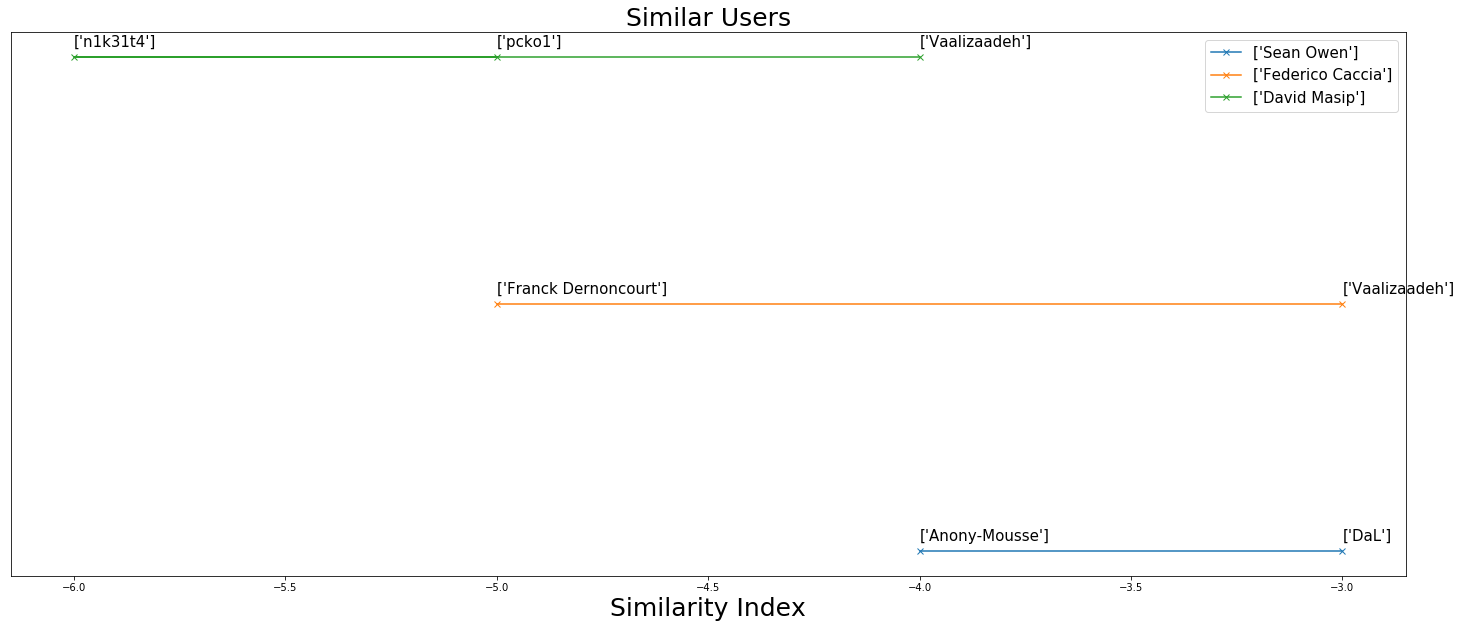

In [232]:
rec_map['29587']

{'30212', '35644', '45264', '8560', '924'}

In [233]:
df_user[df_user['Id'] == '30212']['AboutMe'].values

array([None], dtype=object)